In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
import polars as pl
import pandas as pd
import plotly.graph_objects as go
import utm
import h3

repo_root = Path(os.getcwd()).parent

while not (repo_root / ".git").exists():
    repo_root = repo_root.parent

sys.path.append(str(repo_root))

# set the pandas plotting backend to plotly
pd.options.plotting.backend = "plotly"

## Load Radar Data


In [3]:
## Read in the Data
from src.filtering import Filtering


df = pl.scan_parquet(
    "/Users/max/Library/CloudStorage/Box-Box/Radar-Data/new_format/167882*.parquet"
).collect()


# create the file paths
network_outline_file = repo_root / "geo_data" / "network_outline.geojson"
radar_locations_file = repo_root / "geo_data" / "radar_origins.json"

f = Filtering(
    radar_location_path=radar_locations_file,
    network_boundary_path=network_outline_file,
)

df = (
    df.pipe(f.create_object_id).pipe(f.crop_radius, radius=200)
    # resample to 10 Hz
    .pipe(f.resample, 100)
    # remove objects that travel for very little time
    .pipe(f.filter_short_trajectories, minimum_distance_m=100, minimum_duration_s=5)
    # clip trajectories to not include the constant speed at the end
    .pipe(
        f.clip_trajectory_end,
    )
    # rotate the heading measurements to world coordinates
    # .pipe(f.rotate_heading)
    # # update the centroid coordinates to the actual center of the object
    # .pipe(
    #     f.correct_center,
    #     x_col="utm_x",
    #     y_col="utm_y",
    # )
    # convert the h3 integer to a string
    .pipe(f.int_h3_2_str)
    # filter out objects that are not in the network
    .pipe(f.filter_network_boundaries)
)

function: crop_radius took: 0.7613229751586914 seconds
function: resample took: 2.742626905441284 seconds
function: filter_short_trajectories took: 0.5116140842437744 seconds
function: clip_trajectory_end took: 0.33533382415771484 seconds
function: int_h3_2_str took: 0.5150370597839355 seconds
function: filter_network_boundaries took: 0.07019877433776855 seconds


### Just Look at One TL


In [4]:
interest_df = df.filter(pl.col("ip") == "10.160.7.137")

In [5]:
# make the object ids a categorical
interest_df = interest_df.with_columns(
    pl.col("object_id").cast(pl.Categorical).cast(pl.Int32)
)


In [6]:
# scatter plot a sample of the data
interest_df.sample(1000).to_pandas().plot.scatter(
    x="f32_positionX_m",
    y="f32_positionY_m",
    color="f32_velocityInDir_mps",
)


## Get the Extend of X & Y


In [7]:
interest_df.select(["f32_positionX_m", "f32_positionY_m"]).describe()

describe,f32_positionX_m,f32_positionY_m
str,f64,f64
"""count""",257893.0,257893.0
"""null_count""",0.0,0.0
"""mean""",6.856876,54.401634
"""std""",42.210144,27.064074
"""min""",-142.598419,8.225922
"""max""",155.173599,167.643555
"""median""",17.294313,45.145756


## Sliding Window


In [8]:
import numpy as np
from skimage.feature.peak import peak_local_max

# create a grid of the data
x_bins = np.arange(
    interest_df["f32_positionX_m"].min(), interest_df["f32_positionX_m"].max(), 0.05
)
y_bins = np.arange(
    interest_df["f32_positionY_m"].min(), interest_df["f32_positionY_m"].max(), 0.05
)
hist, xedges, yedges = np.histogram2d(
    interest_df["f32_positionX_m"],
    interest_df["f32_positionY_m"],
    bins=[x_bins, y_bins],
    # weights=interest_df["f32_velocityInDir_mps"],
    # normed=False,
)


In [9]:
# # gaussian blur the histogram and shift it
from scipy.ndimage import gaussian_filter, maximum_filter, gaussian_laplace, fourier_gaussian

# # blur the histogram
# hist = fourier_gaussian(hist, sigma=2)
hist = gaussian_filter(hist, sigma=5)
# hist = maximum_filter(hist, size=5)

# find the peaks
peaks = peak_local_max(
    hist,
    min_distance=3,
    exclude_border=False,
)

peak_list = list(
    map(
        list,
        zip(
            xedges[peaks[:, 0]],
            yedges[peaks[:, 1]],
        ),
    )
)

peak_points = np.array(list(peak_list))


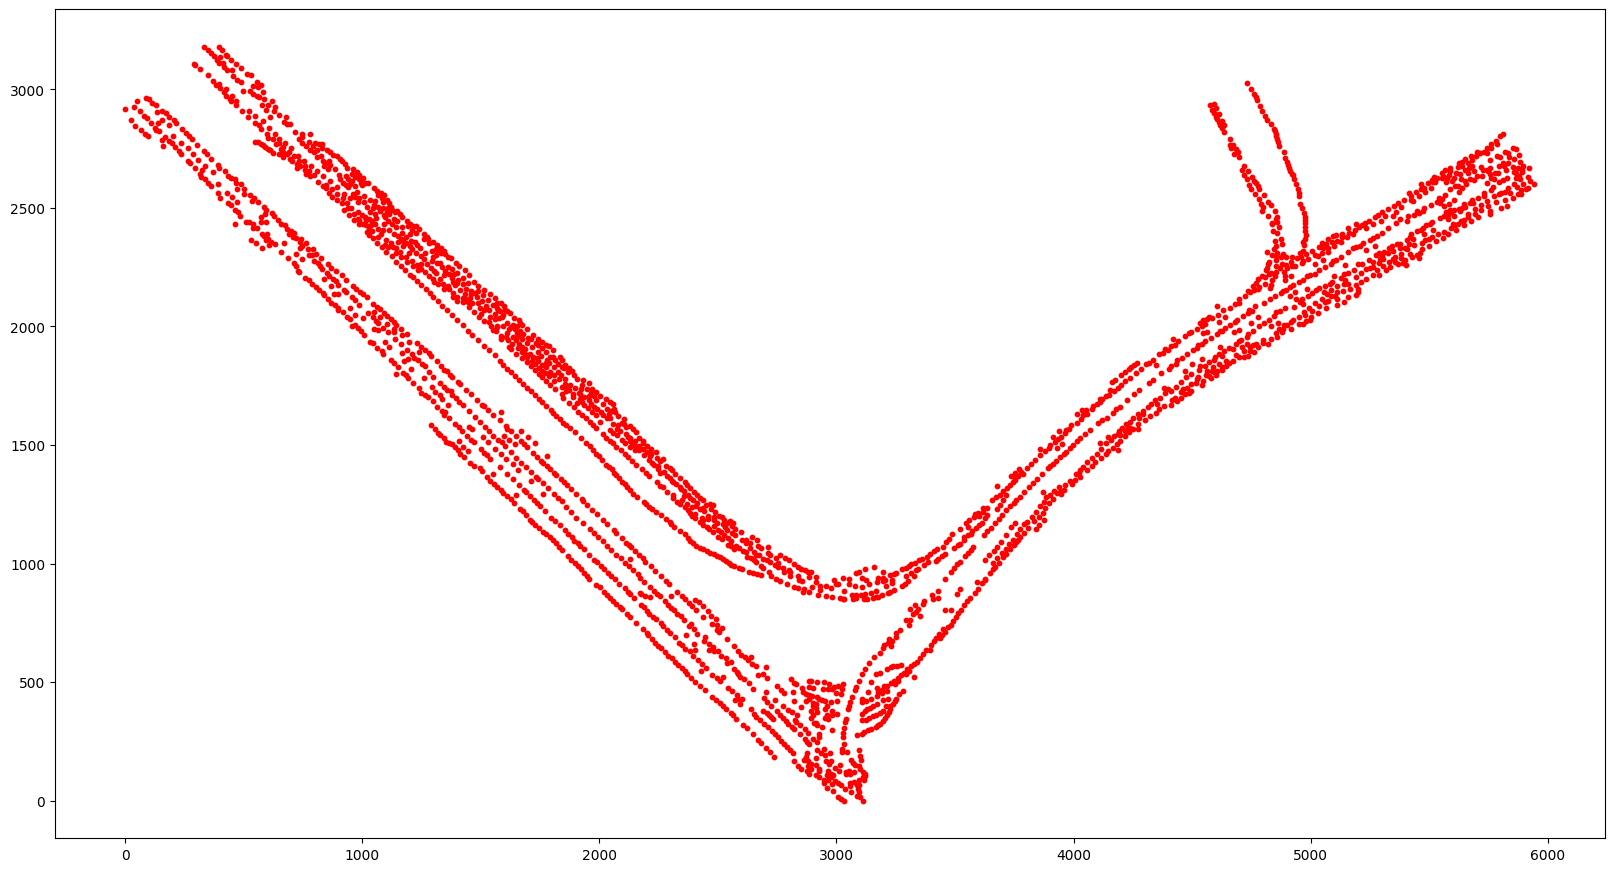

In [10]:
# show the peaks
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(peaks[:, 0], peaks[:, 1], c="r", s=10)

# set axis equal
ax.set_aspect("equal")

### Create a DataFrame Snapped to the Grid


In [12]:
from scipy.spatial.distance import cdist
from sklearn.neighbors import KDTree

if "row_nr" not in interest_df.columns:
    interest_df = interest_df.with_row_count()

points = interest_df.select(
    [
        "f32_positionX_m",
        "f32_positionY_m",
    ]
).to_numpy()
row_nr = interest_df["row_nr"]

# get the peak points
peak_points = np.array(peak_list)

kd = KDTree(peak_points)
d, inds = kd.query(points, k=1)

In [13]:
# get the matching peak points
closest_peak_points = peak_points[inds.flatten()]

# merge back into the interest_df
snapped_df = (
    interest_df.join(
        pl.DataFrame(
            {
                "closest_peak_x": closest_peak_points[:, 0],
                "closest_peak_y": closest_peak_points[:, 1],
                "row_nr": row_nr,
            }
        ),
        on="row_nr",
    )
    .with_columns(
        [
            pl.col("closest_peak_x").round(2).cast(pl.Float32).alias("closest_peak_x"),
            pl.col("closest_peak_y").round(2).cast(pl.Float32).alias("closest_peak_y"),
        ]
    )
    .groupby(["object_id", "closest_peak_x", "closest_peak_y"])
    .agg(
        pl.col("f32_velocityInDir_mps").alias("f32_velocityInDir_mps"),
        pl.col("f32_positionX_m").mean().cast(pl.Float32).alias("actual_x"),
        pl.col("f32_positionY_m").mean().cast(pl.Float32).alias("actual_y"),
        pl.col("epoch_time").first().alias("epoch_time"),
    )
    .sort(["object_id", "epoch_time"])
    .with_columns(
        [
            pl.col("closest_peak_x").shift(-1).over("object_id").alias("next_x"),
            pl.col("closest_peak_y").shift(-1).over("object_id").alias("next_y"),
        ]
    )
)

In [14]:
birth_death_df = (
    snapped_df.groupby(
        "object_id",
    )
    .agg(
        [
            # pl.count().alias('count'),
            pl.col("closest_peak_x").round(2).first().alias("birth_x"),
            pl.col("closest_peak_y").round(2).first().alias("birth_y"),
            pl.col("closest_peak_x").round(2).last().alias("death_x"),
            pl.col("closest_peak_y").round(2).last().alias("death_y"),
        ]
    )
    .groupby(
        [
            "birth_x",
            "birth_y",
            "death_x",
            "death_y",
        ]
    )
    .count()
    .sort("count", descending=True)
    .filter(pl.col("count") > 1)
    .with_columns(
        [
            pl.concat_list(
                [
                    pl.col("birth_x"),
                    pl.col("birth_y"),
                ]
            ).alias("birth"),
            pl.concat_list(
                [
                    pl.col("death_x"),
                    pl.col("death_y"),
                ]
            ).alias("death"),
        ]
    )
    .to_pandas()
)


birth_death_df[["birth", "death"]] = birth_death_df[["birth", "death"]].applymap(
    lambda x: tuple(round(v, 2) for v in x.tolist())
)


### Vehicle Clustering


In [15]:
vehicles = (
    snapped_df.with_columns(
        pl.concat_list(["closest_peak_x", "closest_peak_y"]).alias("vector")
    )
    .groupby("object_id")
    .agg(["vector"])
    .select(["object_id", "vector"])
    .to_pandas()
)

In [16]:
# import numpy as np
# from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
# from functools import partial
# from tqdm import tqdm
# from src.distance import calculate_distance
# import itertools


# def parallel_distance_matrix(vehicles_, vehicle_ids, common_h3_dict):
#     distance_matrix = np.zeros((len(vehicles_), len(vehicles_)))

#     with ProcessPoolExecutor(max_workers=8) as executor:
#         partial_func = partial(calculate_distance, vehicles_=vehicles_)

#         # create a iterator
#         indexes = []
#         passes = set()
#         for i in range(len(vehicles_)):
#             indexes.append([(i, i, 0)])
#             for j in range(i + 1, len(vehicles_)):
#                 # v1 = vehicle_ids[i]
#                 # v2 = vehicle_ids[j]


#                 # v2 = vehicle_ids[j]
#                 # if (
#                 #     {v1, v2} not in passes
#                 #     and v1 in common_h3_dict
#                 #     and v2 in common_h3_dict[v1]
#                 # ):
#                 indexes[-1].append((i, j, 0))
#                 # else:
#                 #     passes.add((i, j))
#                 #     indexes[-1].append((i, j, np.inf))

#         # return indexes

#         results = list(
#             tqdm(
#                 executor.map(partial_func, indexes),
#                 total=len(vehicles_),
#                 desc="Calculating distances",
#             )
#         )

#     # # Sort the results based on the index
#     results.sort(key=lambda x: x[0])

#     # # Construct the distance matrix
#     for i, row in results:
#         distance_matrix[i] = row

#     return distance_matrix


# distance_matrix = parallel_distance_matrix(
#     vehicles["vector"].apply(lambda x: np.array(x.tolist())).to_list(),
#     vehicles["object_id"].to_list(),
#     {},
# )


In [17]:
# # mirror the matrix on the diagonal
# distance_matrix = (
#     distance_matrix + distance_matrix.T - np.diag(distance_matrix.diagonal())
# )

# # fill the inf values with the max value (not )
# distance_matrix[distance_matrix == np.inf] = distance_matrix[
#     distance_matrix != np.inf
# ].max()


In [18]:
# from sklearn.cluster import DBSCAN

# cl = DBSCAN(eps=10, min_samples=2, metric="precomputed")
# cl.fit(distance_matrix)

# print(np.unique(cl.labels_))


In [19]:
# # plot the clusters
# import plotly.graph_objects as go
# import plotly.express as px
# from scipy.spatial import ConvexHull
# import alphashape

# fig = go.Figure()

# label_dfs = {}

# # create a set of colors for the clusters
# colors = (
#     px.colors.qualitative.D3_r
#     + px.colors.qualitative.Plotly_r
#     + px.colors.qualitative.Alphabet_r
#     + px.colors.qualitative.Dark24_r
# )  # + px.colors.qualitative.Dark24_r + px.colors.qualitative.Pastel_r + px.colors.qualitative.Prism_r + px.colors.qualitative.Set1_r + px.colors.qualitative.Set2_r + px.colors.qualitative.Set3_r

# for j, label in enumerate(np.unique(cl.labels_)):
#     if label == -1:
#         continue

#     # get the points in the cluster
#     points = []
#     vehicles_ = []
#     for i in np.where(cl.labels_ == label)[0]:
#         # points.append(vehicles_[i])
#         vehicles_.append(vehicles["object_id"].iloc[i])

#     label_dfs[label] = vehicles_

#     # get the points in the cluster
#     _df = snapped_df.filter(pl.col("object_id").is_in(vehicles_))
#     _df = _df.sample(
#         min(1000, len(_df)),
#     )

#     fig.add_trace(
#         go.Scatter(
#             x=_df["closest_peak_x"],
#             y=_df["closest_peak_y"],
#             mode="markers",
#             name=f"cluster {label}",
#             # fill="toself",
#             # fillcolor=color,
#             # line_color=color,
#         )
#     )

# # make the plot square
# fig.update_layout(
#     width=800,
#     height=800,
#     autosize=False,
#     showlegend=True,
#     xaxis=dict(
#         scaleanchor="y",
#         scaleratio=1,
#     ),
# )

# # make figure span the whole figure
# fig.update_layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0,
#         pad=0,
#     )
# )

# fig.show()
# # fig.show(renderer="png")


### Create a DataFrame with the Grid


In [20]:
import itertools


nn = kd.query_radius(peak_points, r=20)

matches = [[peak_list[i], peak_list[j]] for i, js in enumerate(nn) for j in js]


In [21]:
peak_df = (
    pl.DataFrame(
        {
            "pairs": matches,
        }
    )
    .with_columns(
        [
            pl.col("pairs").arr.first().alias("start"),
            pl.col("pairs").arr.last().alias("end"),
        ]
    )
    .with_columns(
        [
            pl.col("start").arr.first().cast(pl.Float32).round(2).alias("start_x"),
            pl.col("start").arr.last().cast(pl.Float32).round(2).alias("start_y"),
            pl.col("end").arr.first().cast(pl.Float32).round(2).alias("end_x"),
            pl.col("end").arr.last().cast(pl.Float32).round(2).alias("end_y"),
        ]
    )
)

In [22]:
peak_df = (
    peak_df.lazy()
    .join(
        snapped_df.select(
            ["closest_peak_x", "closest_peak_y", "next_x", "next_y", "object_id"]
        ).lazy(),
        left_on=["start_x", "start_y", "end_x", "end_y"],
        right_on=["closest_peak_x", "closest_peak_y", "next_x", "next_y"],
        how="inner",
        suffix="_start",
    )
    .groupby(["start_x", "start_y", "end_x", "end_y"])
    .agg(
        [
            pl.col("object_id").count().alias("count"),
            pl.col("start").first().alias("start"),
            pl.col("end").first().alias("end"),
        ]
    )
    .collect()
)

In [23]:
peak_df_pd = peak_df.to_pandas()

# turn the start and end into tuples
peak_df_pd[["start", "end"]] = peak_df_pd[["start", "end"]].applymap(
    lambda x: tuple(np.round(x, 2).tolist())
)

peak_df_pd = peak_df_pd.loc[peak_df_pd["count"] > 0]

In [24]:
peak_df_pd.sort_values("start_x", ascending=False)

,start_x,start_y,end_x,end_y,count,start,end
4507,144.899994,133.729996,147.100006,133.630005,5,"(144.9, 133.73)","(147.1, 133.63)"
2754,143.300003,132.630005,142.500000,135.529999,2,"(143.3, 132.63)","(142.5, 135.53)"
2183,143.300003,132.630005,144.899994,133.729996,37,"(143.3, 132.63)","(144.9, 133.73)"
817,143.300003,132.630005,147.100006,133.630005,3,"(143.3, 132.63)","(147.1, 133.63)"
3826,142.500000,135.529999,144.899994,133.729996,5,"(142.5, 135.53)","(144.9, 133.73)"
...,...,...,...,...,...,...,...
2829,-134.500000,143.830002,-130.100006,143.929993,3,"(-134.5, 143.83)","(-130.1, 143.93)"
1976,-134.500000,143.830002,-132.000000,145.929993,3,"(-134.5, 143.83)","(-132.0, 145.93)"
1641,-134.500000,143.830002,-129.500000,143.229996,2,"(-134.5, 143.83)","(-129.5, 143.23)"
3235,-136.899994,145.729996,-134.500000,143.830002,8,"(-136.9, 145.73)","(-134.5, 143.83)"


### Make a Graph


In [56]:
import networkx as nx


In [68]:
G = nx.from_pandas_edgelist(
    peak_df_pd, source="start", target="end", edge_attr="count", create_using=nx.DiGraph
)


In [69]:
def update_weights():
    # add a weight to the node as the sum of incoming edges
    for node in G.nodes:
        G.nodes[node]["weight"] = sum(n[-1] for n in G.in_edges(node, data="count"))
        if G.nodes[node]["weight"] == 0:
            G.nodes[node]["weight"] = sum(
                n[-1] for n in G.out_edges(node, data="count")
            )


update_weights()


### Drop Edges with Count == 1


In [36]:
edges = list(G.edges(data=True))

for edge in edges:
    if edge[2]["count"] < 3:
        G.remove_edge(edge[0], edge[1])

update_weights()


### Drop Nodes with Count == 1


In [55]:
nodes = list(G.nodes(data=True))

for node, data in nodes:
    if data["weight"] < 3:
        G.remove_node(node)

update_weights()


### Drop Edges that Go in Reverse Direction


In [29]:
nodes = list(G.nodes)

for n in nodes:
    incoming = list(G.in_edges(n, data="count"))
    outgoing = list(G.out_edges(n, data="count"))

    for i in incoming:
        for o in outgoing:
            if i[0] == o[1]:
                # this is a reverse edge. Pop it
                G.remove_edge(*o[:2])

update_weights()


### Drop Weak Edges


In [30]:
nodes = list(G.nodes)

for n in nodes:
    drop_connections = []
    from_count = G.nodes[n]["weight"] or 1
    out_edges = list(G.out_edges(n, data=True))
    if len(out_edges) > 1:
        for u, v, data in out_edges:
            percent_to = data["count"] / G.nodes[v]["weight"]
            percent_from = data["count"] / from_count
            if percent_to < 0.3 and percent_from < 0.1 or percent_from < 0.05:
                drop_connections.append((u, v))
    for u, v in drop_connections:
        G.remove_edge(u, v)
    update_weights()


### Simplify the graph


In [80]:
# connect nodes that have a single connection
nodes = list(G.nodes)

for n in nodes:
    out_edges = list(G.out_edges(n, data=True))
    in_edges = list(G.in_edges(n, data=True))
    if (len(out_edges) == 1) and (len(in_edges) == 1):
        u, v, data = out_edges[0]
        G.add_edge(in_edges[0][0], v, count=data.get("count", 0))

        # remove the old edge
        G.remove_edge(u, v)

        # remove node
        G.remove_node(u)

    if not out_edges and not in_edges:
        G.remove_node(n)


### Drop Edges That Have Nodes that have Degree > 4


In [32]:
# nodes = list(G.nodes)

# for n in nodes:
#     # get the degree of the node
#     degree = G.degree(n)

#     # if the degree is 4, its too noisy, drop the least connected node
#     if degree == 4:

#         out_edges = list(G.out_edges(n, data=True))

#         # get the node with the least connections
#         min_node = min(out_edges, key=lambda x: x[-1]['count'])

#         # remove the edge
#         G.remove_edge(min_node[0], min_node[1])

#         # remove the node
#         G.remove_node(min_node[1])


### Drop Edges With High Angle


In [70]:
# get the angle between the two edges
def get_angle(edge1, edge2):
    # Calculate the direction vectors for the lines
    direction_vector1 = edge1[1] - edge1[0]
    direction_vector2 = edge2[0] - edge2[1]
    v1_u = direction_vector1 / np.linalg.norm(direction_vector1)
    v2_u = direction_vector2 / np.linalg.norm(direction_vector2)
    dot = np.dot(v1_u, v2_u)
    det = np.linalg.det([v1_u, v2_u])
    angle = np.arctan2(det, dot)
    return abs(np.rad2deg(angle))


nodes = list(G.nodes(data=True))
nodes.sort(key=lambda x: x[1]["weight"], reverse=True)

for n in nodes:
    if n[0][0] == 10.3 and n[0][1] == 29.03:
        print(n)

    # get the in edges
    in_edges = list(G.in_edges(n[0], data=True))
    # get the out edges
    out_edges = list(G.out_edges(n[0], data=True))

    # sort the edges by count
    in_edges.sort(key=lambda x: x[-1]["count"], reverse=True)
    out_edges.sort(key=lambda x: x[-1]["count"], reverse=True)

    if not in_edges or not out_edges:
        continue

    # get the count of the top 2 in edges
    if len(in_edges) > 2:
        in_counts = [i[-1]["count"] for i in in_edges]
        ps = np.array(in_counts) / sum(in_counts)
        if ps[0] > 0.60:
            # calulate the angle between the two top edges
            angle = get_angle(np.array(in_edges[0][:-1]), np.array(out_edges[0][:-1]))
            # if the angle is near 90, cut it out
            if abs((90 - abs(angle))) < 20:
                rm_edge = out_edges.pop(0)
                G.remove_edge(*rm_edge[:2])
            if not out_edges:
                continue
            in_edges = [
                # make a new edge from the start of the top in
                # edge to the end of the top out edge
                [in_edges[0][0], out_edges[0][1], {}]
            ]

    if len(out_edges) > 1:
        for v in out_edges:
            remover_count = 0
            for d_in in in_edges:
                # calculate the angle between the new edge and the out edge
                angle = get_angle(np.array(d_in[:-1]), np.array(v[:-1]))
                a = abs(angle)
                if (abs((180 - a)) > 20) or (abs((90 - a)) < 30):
                    remover_count += 1
            if remover_count == len(in_edges) and G.has_edge(*v[:-1]):
                G.remove_edge(*v[:-1])

update_weights()

((10.3, 29.03), {'weight': 618})


In [71]:
def distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

NetworkXNoPath: No path between (-130.7, 149.63) and (-2.7, 24.23).

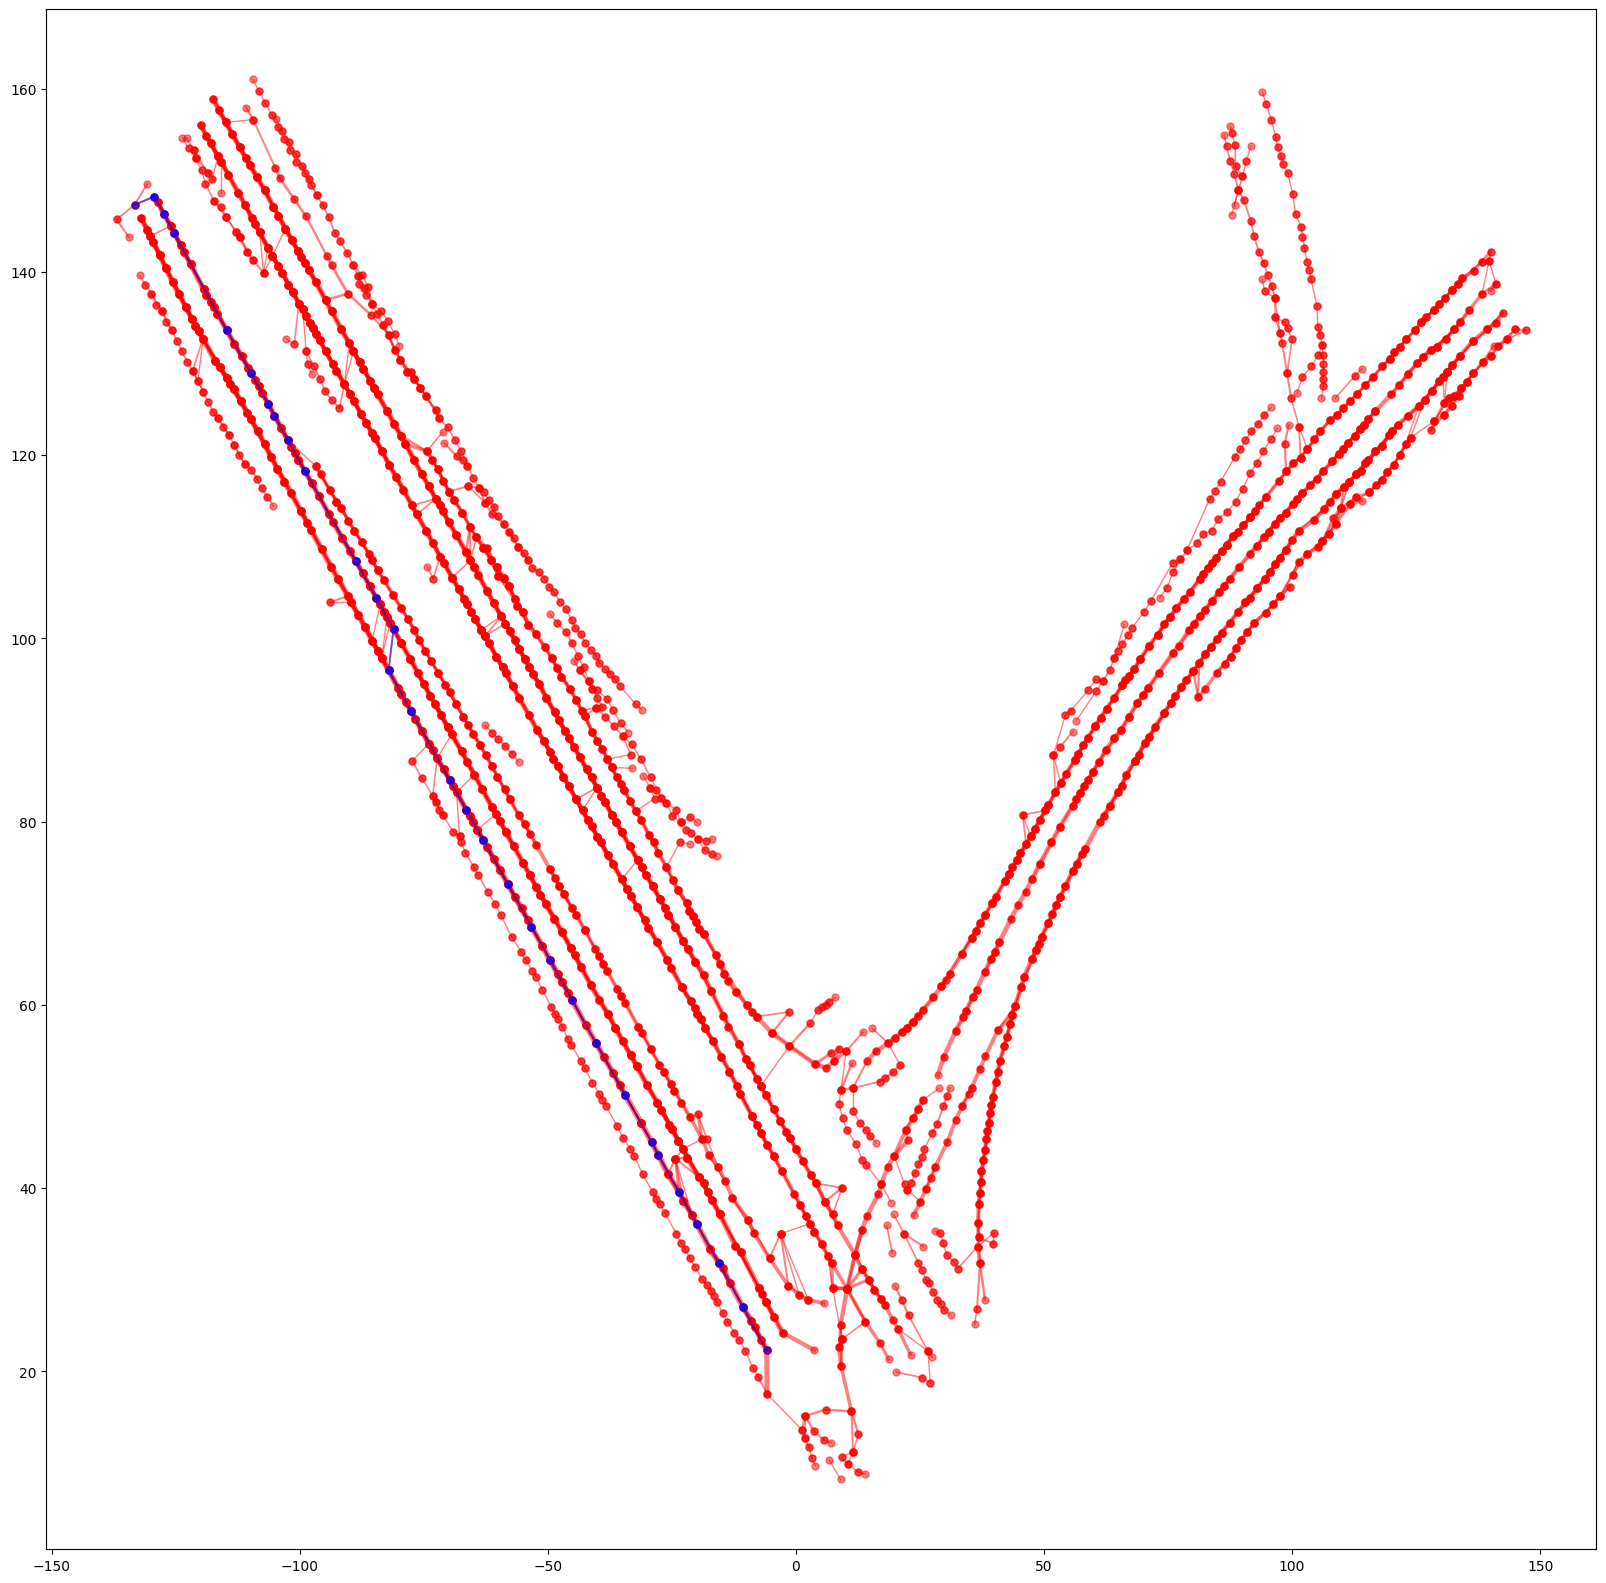

In [72]:
# plot the nodes on a map
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))

for node in G.nodes:
    # plot the connections as lines
    for edge in G.edges(node):
        # plot with the weight as the width, and a arrow in the direction of the edge
        ax.plot(
            [edge[0][0], edge[1][0]],
            [edge[0][1], edge[1][1]],
            c="r",
            linewidth=max(G.edges[edge]["count"] ** (1 / 5), 1),
            alpha=0.5,
            # add an arrow to the end of the line
            marker="o",
            markersize=5,
            markerfacecolor="r",
            markeredgecolor="r",
        )


for row in birth_death_df.iloc[:100].iterrows():
    # get path from birth to death
    # try:
    path = nx.shortest_path(
        G,
        tuple(row[1]["birth"]),
        tuple(row[1]["death"]),
        weight=lambda u, v, d: distance(u, v),
    )
    # except:
    #     continue

    # plot the path
    for i in range(len(path) - 1):
        # get the edge
        edge = (path[i], path[i + 1])

        # plot with the weight as the width, and a arrow in the direction of the edge
        ax.plot(
            [edge[0][0], edge[1][0]],
            [edge[0][1], edge[1][1]],
            c="b",
            alpha=0.5,
            # add an arrow to the end of the line
            marker="o",
            markersize=5,
            markerfacecolor="b",
            markeredgecolor="b",
        )


# make the axis equal
ax.set_aspect("equal")


In [63]:
import plotly.graph_objects as go

# Initialize a Plotly figure
fig = go.Figure()

# Add edges to the figure
for node in G.nodes:
    for edge in G.edges(node):
        fig.add_trace(
            go.Scatter(
                x=[edge[0][0], edge[1][0]],
                y=[edge[0][1], edge[1][1]],
                mode="lines+markers",
                line=dict(color="red", width=max(G.edges[edge]["count"] ** (1 / 5), 1)),
                opacity=0.5,
                marker=dict(size=5, color="red"),
                # hovertemplate='From: (%{x[0]}, %{y[0]})<br>To: (%{x[1]}, %{y[1]})<extra></extra>',
                showlegend=False,
            )
        )

# # Add birth and death paths to the figure
# for row in birth_death_df.iloc[:100].iterrows():
#     try:
#         path = nx.shortest_path(
#             G,
#             tuple(row[1]["birth"]),
#             tuple(row[1]["death"]),
#             weight=lambda u, v, d: distance(u, v),
#         )
#     except:
#         continue

#     for i in range(len(path) - 1):
#         edge = (path[i], path[i + 1])
#         fig.add_trace(
#             go.Scatter(
#                 x=[edge[0][0], edge[1][0]],
#                 y=[edge[0][1], edge[1][1]],
#                 mode="lines+markers",
#                 line=dict(color="blue"),
#                 opacity=0.5,
#                 marker=dict(size=5, color="blue"),
#                 hovertemplate="From: %{x[0]}, %{y[0]}<br>To: %{x[1]}, %{y[1]}<br>",
#                 showlegend=False,
#             )
#         )

# make the plot square
fig.update_layout(
    xaxis=dict(
        scaleanchor="y",
        scaleratio=1,
    ),
)

# Show the plot
fig.show()